# NPLM Test notebook

## Imports

In [1]:
import torch 
import h5py
import os 
import sys

import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
sys.path.insert(0, "../src")
from plot_utils import plot_ref_data, plot_ref_data_reco, plot_loss_history
from analysis_utils import compute_df, produce_bins, save_binning, load_binning
from nn_utils import NPLMnetwork, loss_function

## Config

In [64]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda


In [4]:
hep.style.use(hep.style.CMS)

## Constants

In [5]:
# Set random seed
SEED = 1231244
torch.manual_seed(SEED)
np.random.seed(SEED)

# Plotting parameters
FONTSIZE  = 24
FIGSIZE   = (10, 8)
RATIOSIZE = (10, 10)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)
    
DATA_PATH = "./data/"
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

## NPLM

### Import 5D data

In [6]:
DATA_PATH = "/home/ubuntu/NPLM.torch/notebooks/data/"
Data_dir  = [DATA_PATH+file+'/' for file in os.listdir(DATA_PATH)]
# DATA_file = [row for row in [os.listdir(d) for d in (Data_dir)]]
DATA = [row+item for row in Data_dir for item in os.listdir(row)]
DATA = [file for file in DATA if not "/._" in file]

REF_file  = [file for file in DATA if "DiLepton_SM" in file ]
DATA_file = [file for file in DATA if not "DiLepton_SM" in file]

print("the number of files for R are:  ", len(REF_file))
print("the number of files for Hw are: ", len(DATA_file) )


the number of files for R are:   66
the number of files for Hw are:  69


In [7]:
REF_file[48]

'/home/ubuntu/NPLM.torch/notebooks/data/DiLepton_SM/DiLepton_SM59.h5'

### Dataset class

In [8]:
from torch.utils.data import Dataset

class Dataset5D(Dataset):

    # return a tensor of the data contained in a single file

    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        
        with h5py.File(file_path, 'r') as f:
            # Select only the 5 features
            pt1  = torch.tensor(f['pt1'][:])
            pt2  = torch.tensor(f['pt2'][:])
            eta1 = torch.tensor(f['eta1'][:])
            eta2 = torch.tensor(f['eta2'][:])
            delta_phi = torch.tensor(f['delta_phi'][:])
            
            features = torch.stack([pt1,pt2,eta1,eta2,delta_phi], dim=1)
        return features
    

In [9]:
'''
LOOK IF THERE ARE SOME CORRUPTED FILES
'''
print("REF:")
ref_dataset = Dataset5D(REF_file)
ref_list = []
for i in range(len(ref_dataset)):
    try:
        ref_list.append(ref_dataset[i])
    except Exception as e:
        print(i)

print("NP:")
np_dataset = Dataset5D(DATA_file)
data_list = []
for i in range(len(np_dataset)):
    try:
        data_list.append(np_dataset[i])
    except Exception as e:
        print(i)

del data_list, ref_list

REF:
48
NP:
29


In [10]:
# CONCATENATE ALL THE FILES TENSORS

# REFERENCE DATASET
ref_dataset = Dataset5D(REF_file)
REF_FEAT = torch.cat([ref_dataset[i] for i in range(len(ref_dataset)) if i!=48], dim=0)
print(REF_FEAT.shape)

# NEW PHYSICS DATASET
np_dataset   = Dataset5D(DATA_file)
DATA_FEAT = torch.cat([np_dataset[i] for i in range(len(np_dataset)) if i!=29], dim=0)
print(DATA_FEAT.shape)

torch.Size([3735456, 5])
torch.Size([3861289, 5])


### Create Dataset

In [24]:
# Statistics       
N_EVENTS_R = REF_FEAT.shape[0]                                                                                                                                        
N_EVENTS_D = DATA_FEAT.shape[0]                                                                                                                                            
N_REF      = 40000
N_BKG      = 8000
N_SIG      = 0  
# Samples weights N_D/N_R
N_R        = N_REF
N_D        = N_BKG

# Training parameters
N_EPOCHS   = 20000  # 3e5
PATIENCE   = 5000

# Network parameters
N_INPUTS     = REF_FEAT.shape[1]
N_OUTPUTS    = 1
ARCHITECTURE = [N_INPUTS, 5,5,5, N_OUTPUTS]
WCLIP        = 5
ACTIVATION   = torch.nn.Sigmoid()


In [17]:
# poisson fluctuate the number of events in each sample
N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

# indeces for the Reference and the BKG dataset
idxs    = torch.multinomial(torch.ones(N_EVENTS_R), num_samples=(N_REF + N_bkg_p), replacement=False)
idx_R   = idxs[:N_REF]
idx_bkg = idxs[:N_bkg_p]
# extract idx_R from all the SM events
feature_ref = REF_FEAT[idx_R]
feature_bkg = REF_FEAT[idx_bkg]

# SIGNAL
# feature_sig = DATA_FEAT[]

feature = torch.cat((feature_ref, feature_bkg), dim=0)


In [46]:
# set target: 0 for ref and 1 for data 
target_ref = torch.zeros((N_REF,1), dtype=torch.float64) #1D
target_bkg = torch.ones((N_bkg_p,1), dtype=torch.float64)
# target_data = torch.ones(())

target = torch.cat((target_ref, target_bkg), dim=0)

# initialize weights as ones * N_D / N_R
weights_ref = torch.ones((N_REF, 1), dtype=torch.float64) * (N_D / N_R)
weights_bkg = torch.ones((N_bkg_p, 1), dtype=torch.float64)

weights = torch.cat((weights_bkg, weights_ref), dim=0)

# concatenate the weights to the target
target = torch.cat((target, weights), dim=1)

In [40]:
print("target: ",target.shape)
print("feature:",feature.shape)

target:  torch.Size([48151, 2])
feature: torch.Size([48151, 5])


### Generate 1D data

### Plot 1D data

In [41]:
# bins = load_binning(path=DATA_PATH, name="binning_1dexpon.h5")
bins = produce_bins(data=feature_ref, method="simple", bins_range=(0, 10), bins_width=0.25)

### Create NPLM model

In [42]:
nplm_model = NPLMnetwork(
    architecture      = ARCHITECTURE,
    activation_func   = ACTIVATION,
    weight_clip_value = WCLIP,
    trainable         = True,
    device            = device
).to(device)

optimizer = torch.optim.Adam(nplm_model.parameters(), lr=0.001)

In [43]:
dof = compute_df(ARCHITECTURE)
print(dof)

96


In [57]:
t = target.type(torch.float32)
f = feature.type(torch.float32)
print(t.dtype)
print(f.dtype)

torch.float32
torch.float32


### Train NPLM model

In [66]:
nplm_model.train_model(
    feature       = f, #[N, 5]
    target        = t, #[N, 2]
    loss_function = loss_function,
    optimizer     = optimizer,
    n_epochs      = N_EPOCHS,
    patience      = 1000,
)

KeyboardInterrupt: 

### Loss function plot

ValueError: x and y must have same first dimension, but have shapes (19650,) and (981,)

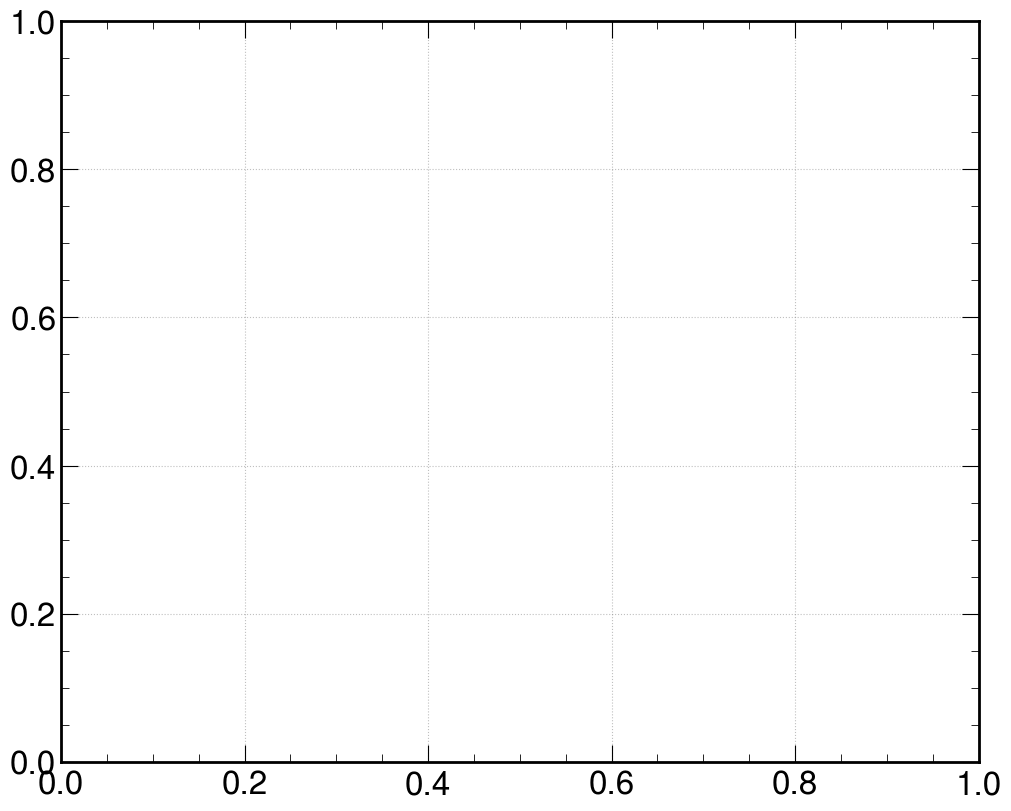

In [63]:
plot_loss_history(
    n_epochs     = N_EPOCHS,
    loss_history = nplm_model.get_losses(),
    epochs_init  = 350,
    epochs_norm  = 1000,
    figsize      = FIGSIZE,
    fontsize     = FONTSIZE,
    cms          = False,
    color        = PALETTE_2[1],
    xlabel       = r"Epochs $\times 10^3$",
    ylabel       = "Loss",
    show_plot    = True,
    save_plot    = False,
    plot_name    = "1dexpon_loss_history",
    plot_path    = PLOT_PATH,
    plot_format  = "png",
    return_fig   = False
)

### Reconstruction

In [39]:
xgrid = torch.arange(bins[0], bins[-1]+0.01, 0.01).to(device)

with torch.no_grad():
    pred = nplm_model(feature[target[:, 0] == 0].to(device))
    grid_pred = nplm_model(xgrid.view(-1, 1))

## Load model